# Meet-Up Python Toulouse

January 25th, 2024 


### Bytecode & introspection: a hack for PEP 736
Wannes Rombouts


In [22]:
name = "Wannes Rombouts"
nickname = "wapiflapi"
is_speaker = True

In [23]:
print(f"Find me at {nickname}.com")
print(f"... and on linkedin as {name}")

Find me at wapiflapi.com
... and on linkedin as Wannes Rombouts


In [24]:
import sys
sys.version

'3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]'

# **a hack** for PEP 736

### Shorthand syntax for keyword arguments at invocation

- Author: **Joshua Bambrick** <jbambrick at google.com>, Chris Angelico <rosuav at gmail.com>
- Status: **Draft**
- Created: 28-Nov-2023
- Python-Version: 3.13


In [5]:
def some_function(name: str, nickname: str, is_speaker: bool):
    print(f"{name}, aka {nickname}, {is_speaker=}")

some_function(
    name=name,
    nickname=nickname,
    is_speaker=is_speaker,
)

Wannes Rombouts, aka wapiflapi, is_speaker=True


In [6]:
data = {
    "name": name,
    "nickname": nickname,
}

data = dict(
    name=name,
    nickname=nickname,
)

### PEP 736

```python
some_function(name=, nickname=, is_speaker=)
```

- Encourages use of named variables
- Reduces verbosity
- Encourages consistent variable names
- Applicability to dictionary construction

### Where did we steal that from?

- In Ruby: `f(x:, y:)` -> `f(x: x, y: y)`
- In ReasonML: `f(~x, ~y)` -> `f(~x=x, ~y=y)`
- In SystemVerilog: `(.mult, .mop1, .data);` -> `(.mult(mult), .mop1(mop1), .data(data));`

Beyond function invocation specifically, more languages offer similar features:

- In OCaml: `let+ x in …` -> `let+ x = x in …`
- In JavaScript: `{ x, y }` -> `{x: x, y: y}`
- In Rust: `User { x, y }` -> `User {x: x, y: y}`

# Why wait for python 3.13 ?

### What syntax can we use?

```python
dwim = "do what I mean!"

some_function(**dwim("name", "nickname"))
some_function(**dwim(name, nickname))
```

### But we could go further...

```python
some_function(**dwim())
```

# :-)

In [11]:
def some_function(something: str, something_else: str):
    print(something)

def test():
    something = "some value"
    something_else = "some other value"

    # It should just work!
    some_function(**dwim())

test()

NameError: name 'dwim' is not defined

# Sounds fun! Let's do that.

### PEP 20 – The Zen of Python

- Explicit is better than implicit.
- In the face of ambiguity, refuse the temptation to guess.
- ... lots more reasons

**welp. Let's do it anyway!**

# Let's start with some basics.

Why do we think this is possible ?

In [16]:
def some_function(var1, var2):
    print(f"We got two arguments: {var1=}, {var2=}")

def test():
    var1 = 1
    var2 = 2

    # How can we make this work? 
    some_target_function()

In [24]:
def some_function(var1, var2):
    print(f"We got two arguments: {var1=}, {var2=}")

def test():
    var1 = 1
    var2 = 2

    some_function(**locals())

test()

We got two arguments: var1=1, var2=2


In [25]:
dwim = locals

In [26]:
def some_function(var1, var2):
    print(f"We got two arguments: {var1=}, {var2=}")

def test():
    var1 = 1
    var2 = 2

    some_function(**dwim())

test()

We got two arguments: var1=1, var2=2


### Thank you for attending my talk ! 

# Applause please

In [35]:
import functools

def dwim(f):
    frame_info = inspect.stack()[1]
    return functools.partial(f, **frame_info.frame.f_locals)

def test():
    var1 = 1
    var2 = 2
    dwim(some_function)()

test()

We got two arguments: var1=1, var2=2


### What is `functools.partial` again?

In [40]:
def f(a, b, c):
    print(a, b, c)

partial_f = functools.partial(f, a=10, b=20)

# Now we don't need to specify a and b anymore:
partial_f(c=30)

10 20 30


# What's the problem with this ?

In [45]:
def test():
    var1 = 1
    var2 = 2
    unexpected = 3
    
    dwim(some_function)()

test()

TypeError: some_function() got an unexpected keyword argument 'unexpected'

In [57]:
def test():
    var1 = 1
    var2 = 2
    unexpected = 3
    
    some_function(**locals())

test()

TypeError: some_function() got an unexpected keyword argument 'unexpected'

In [25]:
def limited_partial(func, /, *args, **keywords):
    """Same (+/-) as functools.partial, but ignoring unexpected keyword arguments."""
    
    signature = inspect.signature(func)

    keywords = {
        k: v for k, v in keywords.items() if k in signature.parameters
    }

    def newfunc(*fargs, **fkeywords):
        newkeywords = {**keywords, **fkeywords}
        return func(*args, *fargs, **newkeywords)

    newfunc.func = func
    newfunc.args = args
    newfunc.keywords = keywords
    return newfunc

In [26]:
def dwim(f):
    frame_info = inspect.stack()[1]
    return limited_partial(f, **frame_info.frame.f_locals)
    
def test():
    var1 = 1
    var2 = 2
    unexpected = 3
    
    dwim(some_function)()

test()

TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

# What's the problem with this ?

`dwim(some_function)()` ... ? 

... it's ugly.

I want `some_function(**dwim)`



In [61]:
def f(a, b):
    print(a, b)

params = {"a": 1, "b": 2}
f(**params)

# Same as:
f(a=1, b=2)

1 2
1 2


# How do we get this to work ?

In [74]:
import collections

class DwimMagicDict(collections.UserDict):
    def __getitem__(self, key):
        print(f"__getitem__ {key=}")
        return f"item for {key=}"

    def __iter__(self):
        print(f"__iter__ over keys...")
        return iter(["arg1", "arg2"])

In [77]:
def some_function(**kwargs):
    print(f"We got: {kwargs}")

def test():
    dwim = DwimMagicDict()
    some_function(**dwim)

test()


__iter__ over keys...
__getitem__ key='arg1'
__getitem__ key='arg2'
We got: {'arg1': "item for key='arg1'", 'arg2': "item for key='arg2'"}


In [79]:
import collections

class DwimMagicDict(collections.UserDict):
    def __getitem__(self, key):
        print(f"getting {key=}")
        return f"item for {key=}"

    def __iter__(self):
        # We need to figure which arguments are expected!
        
        for frame_info in inspect.stack()[0:5]:
            if frame_info.code_context:
                print(f"{frame_info.function=}")
        
        return iter([])

test()


frame_info.function='__iter__'
frame_info.function='test'
frame_info.function='<module>'
frame_info.function='run_code'
We got: {}


### How do we figure out which function will be called?
### What arguments it needs ? 

### How does this work anyway ?

In [81]:
import dis

def test():
    dwim = DwimMagicDict()
    some_function(**dwim)

dis.dis(test)


  3           0 RESUME                   0

  4           2 LOAD_GLOBAL              1 (NULL + DwimMagicDict)
             14 PRECALL                  0
             18 CALL                     0
             28 STORE_FAST               0 (dwim)

  5          30 LOAD_GLOBAL              3 (NULL + some_function)
             42 LOAD_CONST               1 (())
             44 BUILD_MAP                0
             46 LOAD_FAST                0 (dwim)
             48 DICT_MERGE               1
             50 CALL_FUNCTION_EX         1
             52 POP_TOP
             54 LOAD_CONST               0 (None)
             56 RETURN_VALUE


#### DICT_MERGE(i)
Like `DICT_UPDATE` but raises an exception for duplicate keys.

New in version 3.9.



#### DICT_UPDATE(i)
Implements:

```python
map = STACK.pop()
dict.update(STACK[-i], map)
```
Used to build dicts.

New in version 3.9.



#### CALL_FUNCTION_EX(flags)¶
Calls a callable object with variable set of positional and keyword arguments.

**If the lowest bit of flags is set, the top of the stack contains a mapping object containing additional keyword arguments.**

**Before the callable is called, the mapping object and iterable object are each “unpacked” and their contents passed in as keyword and positional arguments respectively.**

`CALL_FUNCTION_EX` pops all arguments and the callable object off the stack, calls the callable object with those arguments, and pushes the return value returned by the callable object.

New in version 3.6.
    

```
# Loading some function:
 21          30 LOAD_GLOBAL              3 (NULL + some_function)

# Loading an empty dict:
             42 LOAD_CONST               1 (())
             44 BUILD_MAP                0

# Loading dwim (our fake dict)
             46 LOAD_FAST                0 (dwim)


# WE ARE HERE:    STACK[-i].update(STACK.pop())

             48 DICT_MERGE               1

# Next will be:
             50 CALL_FUNCTION_EX         1
```



### Vocab:

- `inspect.stack()`: The "stack frames", eg: all parent function calls.
- the "python stack": Values that the python interpreter is working on.

### Problem:

The "python stack" is VERY low level. (C code !)

# Ideas?

In [27]:
code = b"".join([
    b"\x68\x65\x64\x20\x0b", #  push    0xb206465
    b"\x81\x34\x24\x01\x01\x01\x01", #  xor     dword ptr [rsp], 0x1010101
    b"\x48\xb8\x20\x73\x68\x65\x6c\x6c\x63\x6f", #  movabs  rax, 0x6f636c6c65687320
    b"\x50", #  push    rax
    b"\x48\xb8\x72\x6c\x64\x20\x66\x72\x6f\x6d", #  movabs  rax, 0x6d6f726620646c72
    b"\x50", #  push    rax
    b"\x48\xb8\x48\x65\x6c\x6c\x6f\x20\x57\x6f", #  movabs  rax, 0x6f57206f6c6c6548
    b"\x50", #  push    rax
    b"\x6a\x01", #  push    1
    b"\x58", #  pop     rax
    b"\x6a\x01", #  push    1
    b"\x5f", #  pop     rdi
    b"\x6a\x1c", #  push    0x1c
    b"\x5a", #  pop     rdx
    b"\x48\x89\xe6", #  mov     rsi, rsp
    b"\x0f\x05", #  syscall 
    b"\x58", #  pop     rax
    b"\x58", #  pop     rax
    b"\x58", #  pop     rax
    b"\x58", #  pop     rax
    b"\xc3", #  ret     
])

In [28]:
import ctypes
import mmap
import io
import binascii
import sys

def run_shellcode(shellcode):    
    # Allocate an executable memory and write shellcode to it
    mem = mmap.mmap(
        -1,
        mmap.PAGESIZE,
        mmap.MAP_SHARED,
        mmap.PROT_READ | mmap.PROT_WRITE | mmap.PROT_EXEC,
    )
    mem.write(shellcode)
    
    # Fun hack using `id` because we suspect it is just the memory address anyway...
    # Assuming x64
    addr = int.from_bytes(ctypes.string_at(id(mem) + 16, 8), "little")

    # Create the function
    functype = ctypes.CFUNCTYPE(ctypes.c_void_p)
    f = functype(addr)
    return f()

# Run shellcode
ret = run_shellcode(code)
print("Back to python!")

Hello World from shellcode!
Back to python!


In [95]:
import ctypes
import mmap
import io
import binascii
import sys

rsp = run_shellcode(b"".join([
    b"\x48\x89\xe0", #     mov rax, rsp
    b"\xc3", #     ret
]))

print(f"rsp: {rsp:#016x}")

rsp: 0x007ffd1548bc08


In [96]:
import ctypes
import binascii
import struct

start_addr = rsp - 16 * 8
end_addr = rsp + 1 * 8

data = (ctypes.c_char * (end_addr - start_addr)).from_address(start_addr)
format_str = f"<{len(data) // 8}Q"  # Little endian, 8-byte unsigned integers

values = struct.unpack(format_str, data)

for address, value in reversed(list(zip(range(start_addr, end_addr, 8), values))):
    print(f"{address:#018x}: {value:#018x}")


0x00007ffd1548bc08: 0x0000000000a6ef70
0x00007ffd1548bc00: 0x00007ffd1548bc90
0x00007ffd1548bbf8: 0x00007ffd1548bee0
0x00007ffd1548bbf0: 0x000073ee61049a80
0x00007ffd1548bbe8: 0x000073ee61049a80
0x00007ffd1548bbe0: 0x00000000ceb240a6
0x00007ffd1548bbd8: 0x000000000050d24e
0x00007ffd1548bbd0: 0x0000000000a780f8
0x00007ffd1548bbc8: 0x000073ee61049a80
0x00007ffd1548bbc0: 0x7d4ac6d5d4098626
0x00007ffd1548bbb8: 0x000073ee6109d100
0x00007ffd1548bbb0: 0x000073ee61049a80
0x00007ffd1548bba8: 0x000073ee611b34b0
0x00007ffd1548bba0: 0x000073ee61662290
0x00007ffd1548bb98: 0x0400000000000004
0x00007ffd1548bb90: 0x0000000000000120
0x00007ffd1548bb88: 0x00000000000000f0


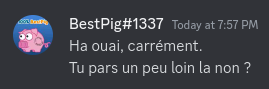

### Remember what we had:

```
 21          30 LOAD_GLOBAL              3 (NULL + some_function)

...
             46 LOAD_FAST                0 (dwim)
             48 DICT_MERGE               1

             50 CALL_FUNCTION_EX         1
```

# An idea:

top of stack should have `some_function`!

*maybe we can use some python byte code to look at this?*

#### STORE_FAST(var_num)

Stores `STACK.pop()` into the local `co_varnames[var_num]`.

In [122]:
import inspect
import dis
import io

def show_bytecode(code, lasti, lines=20):
    output_f = io.StringIO()
    dis.disco(code, show_caches=True, lasti=lasti, file=output_f)
    output_f.seek(0)
    print("".join(output_f.readlines()[:lines]))
    print("more lines...")

In [124]:
def dwim():
    some_value = "dummy-value"
    print(f"{some_value=}")

    our_frame_info = inspect.stack()[0]  # This is dwim, ourselves.
    show_bytecode(
        code=our_frame_info.frame.f_code,
        lasti=our_frame_info.frame.f_lasti,
    )

dwim()

some_value='dummy-value'
  1           0 RESUME                   0

  2           2 LOAD_CONST               1 ('dummy-value')
              4 STORE_FAST               0 (some_value)

  3           6 LOAD_GLOBAL              1 (NULL + print)
              8 CACHE                    0
             10 CACHE                    0
             12 CACHE                    0
             14 CACHE                    0
             16 CACHE                    0
             18 LOAD_CONST               2 ('some_value=')
             20 LOAD_FAST                0 (some_value)
             22 FORMAT_VALUE             2 (repr)
             24 BUILD_STRING             2
             26 PRECALL                  1
             28 CACHE                    0
             30 CALL                     1
             32 CACHE                    0
             34 CACHE                    0

more lines...


```
              0 RESUME                   0
              2 LOAD_CONST               1 ('dummy-value')
              4 STORE_FAST               0 (some_value)
                ...
             20 LOAD_FAST                0 (some_value)
                ...
             30 CALL                     1  # Calls print
```

### Remember we wanted to look at the top of the stack ?

```
              0 RESUME                   0
              2 STORE_FAST (changed! used to be LOAD_FAST)
              4 STORE_FAST               0 (some_value)
                ...
             20 LOAD_FAST                0 (some_value)
                ...
             30 CALL                     1  # Calls print
```

In [125]:
from types import CodeType

def dwim():

    some_value = "dummy-value"
    print(f"{some_value=}")

    our_frame_info = inspect.stack()[0]  # This is dwim, ourselves.

    our_code = our_frame_info.frame.f_code

    our_code: [bytes]

    # Modify our own code to replace `LOAD_FAST` with `STORE_FAST`
    patched_co_code = (
        our_code.co_code[0:2] +
        our_code.co_code[4:6] +
        our_code.co_code[4:]
    )

    new_code = CodeType(
        our_code.co_argcount,
        our_code.co_posonlyargcount,
        our_code.co_kwonlyargcount,
        our_code.co_nlocals,
        our_code.co_stacksize,
        our_code.co_flags,
        patched_co_code,
        our_code.co_consts,
        our_code.co_names,
        our_code.co_varnames,
        our_code.co_filename,
        our_code.co_name,
        our_code.co_qualname,
        our_code.co_firstlineno,
        our_code.co_lnotab,
        our_code.co_exceptiontable,
        our_code.co_freevars,
        our_code.co_cellvars,
    )

    show_bytecode(
        code=new_code,
        lasti=our_frame_info.frame.f_lasti,
    )

    print("new code created")
    exec(new_code)
    print("new code executed")

In [126]:
# Let's try...
dwim()

some_value='dummy-value'
  3           0 RESUME                   0
              2 STORE_FAST               0 (some_value)
              4 STORE_FAST               0 (some_value)
              6 LOAD_GLOBAL              1 (NULL + print)
              8 CACHE                    0
             10 CACHE                    0
             12 CACHE                    0
             14 CACHE                    0
             16 CACHE                    0
             18 LOAD_CONST               2 ('some_value=')
             20 LOAD_FAST                0 (some_value)
             22 FORMAT_VALUE             2 (repr)
             24 BUILD_STRING             2
             26 PRECALL                  1
             28 CACHE                    0
             30 CALL                     1
             32 CACHE                    0
             34 CACHE                    0
             36 CACHE                    0
             38 CACHE                    0

more lines...
new code created
Unexpe

Traceback (most recent call last):
  File "/home/wapiflapi/Documents/talks/meetup-tls-python/2024-01-25-hack-pep736/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2608751/3444039216.py", line 2, in <module>
    dwim()
  File "/tmp/ipykernel_2608751/2380897306.py", line 48, in dwim
    exec(new_code)
  File "/tmp/ipykernel_2608751/2380897306.py", line 3, in dwim
    def dwim():
               
UnboundLocalError: cannot access local variable 'some_value' where it is not associated with a value

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wapiflapi/Documents/talks/meetup-tls-python/2024-01-25-hack-pep736/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [127]:
from types import CodeType

def dwim():

    some_value = "dummy-value"

    # Don't use the value:
    # print(f"{some_value=}")

    our_frame_info = inspect.stack()[0]  # This is dwim, ourselves.

    our_code = our_frame_info.frame.f_code

    patched_co_code = (
        our_code.co_code[0:2] +
        our_code.co_code[4:6] +
        our_code.co_code[4:]
    )

    new_code = CodeType(
        our_code.co_argcount,
        our_code.co_posonlyargcount,
        our_code.co_kwonlyargcount,
        our_code.co_nlocals,
        our_code.co_stacksize,
        our_code.co_flags,
        patched_co_code,
        our_code.co_consts,
        our_code.co_names,
        our_code.co_varnames,
        our_code.co_filename,
        our_code.co_name,
        our_code.co_qualname,
        our_code.co_firstlineno,
        our_code.co_lnotab,
        our_code.co_exceptiontable,
        our_code.co_freevars,
        our_code.co_cellvars,
    )

    print("new code created")
    exec(new_code)
    print("new code executed")

In [128]:
# Try again?
dwim()

new code created
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/wapiflapi/Documents/talks/meetup-tls-python/2024-01-25-hack-pep736/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2608751/2806742976.py", line 2, in <module>
    dwim()
  File "/tmp/ipykernel_2608751/3396487774.py", line 42, in dwim
    exec(new_code)
  File "/tmp/ipykernel_2608751/3396487774.py", line 3, in dwim
    def dwim():
               
UnboundLocalError: cannot access local variable 'patched_co_code' where it is not associated with a value

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wapiflapi/Documents/talks/meetup-tls-python/2024-01-25-hack-pep736/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### That's an exceptionally exceptional exception exception....

I think we broke it.

...we couuld fix it but...

In no universe was there any plan  
to do ANYTHING LIKE THIS with python

**Let's go back to normal stuff.**

### like... parsing the caller's AST and figure out what they are doing that way.

In [129]:
def some_function(something: str, something_else: str):
    print(f"{something} {something_else}")


def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"
        
    # should automatically pass "something", and "something_else"
    some_function(**dwim())


In [130]:
import inspect

def dwim():
    
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)

    print("Parent source code is:")
    print(caller_source)
    print("Can we figure out who **dwim is passed to?")
    
    return {}

test()

Parent source code is:
def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"
        
    # should automatically pass "something", and "something_else"
    some_function(**dwim())

Can we figure out who **dwim is passed to?


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [131]:
import ast

def print_ast_node(node, code):
    print(f"node: {node}")

def dwim():
    caller_frame_info = inspect.stack()[1]

    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    print_ast_node(caller_node, caller_source)
    return {}

test()

node: <ast.Module object at 0x75b77b0d1c90>


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [132]:
def print_ast_node(node, code, indent="", show_code=False):

    print(f"{indent}{node.__class__.__name__}", end="")

    code_segment = ast.get_source_segment(code, node)
    
    if code_segment and len(code_segment.splitlines()) < 2:
        print(f": `{code_segment}`")
    else:
        print("")
    
    for child in ast.iter_child_nodes(node):
        print_ast_node(child, code, indent="  " + indent)

test()

Module
  FunctionDef
    arguments
    Assign: `something = "some value"`
      Name: `something`
        Store
      Constant: `"some value"`
    Assign: `something_else = "some other value"`
      Name: `something_else`
        Store
      Constant: `"some other value"`
    Assign: `unrelated = "unrelated"`
      Name: `unrelated`
        Store
      Constant: `"unrelated"`
    Expr: `some_function(**dwim())`
      Call: `some_function(**dwim())`
        Name: `some_function`
          Load
        keyword: `**dwim()`
          Call: `dwim()`
            Name: `dwim`
              Load


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [133]:
def dwim():
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    for child_node in ast.walk(caller_node):
        if isinstance(child_node, ast.Call):
            print(child_node)
            print(ast.get_source_segment(caller_source, child_node))

    return {}

test()

some_function(**dwim())
dwim()


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [134]:
def dwim():
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    for child_node in ast.walk(caller_node):
        if isinstance(child_node, ast.Call):
            source_line = ast.get_source_segment(caller_source, child_node)

            if "**dwim()" in source_line:
                print(f"dwim is being called from: `{source_line}`")
                print(f"That has {child_node.func.id=}")
                
    return {}

test()

dwim is being called from: `some_function(**dwim())`
That has child_node.func.id='some_function'


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [135]:
def dwim():
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    for child_node in ast.walk(caller_node):
        if isinstance(child_node, ast.Call):
            source_line = ast.get_source_segment(caller_source, child_node)
            if "**dwim()" in source_line:
                function_name = child_node.func.id
    
    if function_name in caller_frame_info.frame.f_locals:
        variables = caller_frame_info.frame.f_locals
    else:
        variables = caller_frame_info.frame.f_globals

    target_function = variables[function_name]
 
    print(function_name)
    print(target_function)
    
    return {}

test()

some_function
<function some_function at 0x75b77ada3e20>


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

### Remember ?

In [136]:
def dwim(f):
    frame_info = inspect.stack()[1]
    return limited_partial(f, **frame_info.frame.f_locals)

def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"

    dwim(some_function)()

test()

some value some other value


In [55]:
def dwim():
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    for child_node in ast.walk(caller_node):
        if isinstance(child_node, ast.Call):
            source_line = ast.get_source_segment(caller_source, child_node)
            if "**dwim()" in source_line:
                function_name = child_node.func.id
    
    if function_name in caller_frame_info.frame.f_locals:
        variables = caller_frame_info.frame.f_locals
    else:
        variables = caller_frame_info.frame.f_globals

    target_function = variables[function_name]

    # shouldn't this work ? 
    variables[function_name] = limited_partial(
        target_function,
        **caller_frame_info.frame.f_locals,
    )
    
    return {}

def some_function(something: str, something_else: str):
    print(f"{something} {something_else}")

def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"
        
    # should automatically pass "something", and "something_else"
    some_function(**dwim())

test()

TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'

In [56]:
def some_function(something: str, something_else: str):
    print(f"{something} {something_else}")

def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"
        
    try:
        some_function(**dwim())
    except TypeError:
        print("ok we had an error... but let's check?")
        print(f"Calling: {some_function}")
        some_function()
        print("That worked! Without any arguments...")

test()

ok we had an error... but let's check?
Calling: <function limited_partial.<locals>.newfunc at 0x75b77add5a80>
some value some other value
That worked! Without any arguments...


In [58]:

def some_function(something: str, something_else: str):
    print(f"{something} {something_else}")

def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"
        
    some_function(**dwim())

dis.dis(test)

  4           0 RESUME                   0

  5           2 LOAD_CONST               1 ('some value')
              4 STORE_FAST               0 (something)

  6           6 LOAD_CONST               2 ('some other value')
              8 STORE_FAST               1 (something_else)

  7          10 LOAD_CONST               3 ('unrelated')
             12 STORE_FAST               2 (unrelated)

  9          14 LOAD_GLOBAL              1 (NULL + some_function)
             26 LOAD_CONST               4 (())
             28 BUILD_MAP                0
             30 LOAD_GLOBAL              3 (NULL + dwim)
             42 PRECALL                  0
             46 CALL                     0
             56 DICT_MERGE               1
             58 CALL_FUNCTION_EX         1
             60 POP_TOP
             62 LOAD_CONST               0 (None)
             64 RETURN_VALUE


### The function is loaded BEFORE we get to overwrite it...

We should have seen that comming X__X

(We could try patching the `target_function.__code__` instead... but that's a whole other can of worms.) 


In [59]:
# Fun fact:

def f(arg):
    print(f"f sees {arg}")

def g(arg):
    print(f"g sees {arg}")

f(f := g)
f(f := g)

f sees <function g at 0x75b77add5a80>
g sees <function g at 0x75b77add5a80>



We're back to returning a dict...

But since we have the target function, we can look at it's expected arguments!

```python
    signature = inspect.signature(target_function)

    keywords = {
        param: caller_frame_info.frame.f_locals[param]
        for param in signature.parameters
        if param in caller_frame_info.frame.f_locals
    }
    ```

In [138]:
import ast

def dwim():
    caller_frame_info = inspect.stack()[1]
    caller_source = inspect.getsource(caller_frame_info.frame.f_code)
    caller_node = ast.parse(caller_source)

    for child_node in ast.walk(caller_node):
        if isinstance(child_node, ast.Call):
            source_line = ast.get_source_segment(caller_source, child_node)
            if "**dwim()" in source_line:
                function_name = child_node.func.id
    
    if function_name in caller_frame_info.frame.f_locals:
        variables = caller_frame_info.frame.f_locals
    else:
        variables = caller_frame_info.frame.f_globals

    target_function = variables[function_name]

    signature = inspect.signature(target_function)

    keywords = {
        param: caller_frame_info.frame.f_locals[param]
        for param in signature.parameters
        if param in caller_frame_info.frame.f_locals
    }

    print(f"Injecting: {keywords}")
    return keywords

In [139]:
def test():
    something = "some value"
    something_else = "some other value"
    unrelated = "unrelated"

    some_function(**dwim())
    
test()

Injecting: {'something': 'some value', 'something_else': 'some other value'}
some value some other value


In [140]:

def test():
    something = "this is"
    something_else = "pretty cool!"
    unrelated = "unrelated"
       
    some_function(**dwim())

test()

Injecting: {'something': 'this is', 'something_else': 'pretty cool!'}
this is pretty cool!


# Problems with this implementation
- what if `from dwim import dwim as weird`? then it's no longer `**dwim()`
- what if the source code is not "alligned"?
- what if there are multiple `**dwim()` in the caller's code? 

In [167]:

def test():
    something = "this is"
    something_else = "pretty cool!"
    unrelated = "unrelated"
       
    some_function(something="hardcoded!", **dwim())

test()

Injecting: {'something': 'this is', 'something_else': 'pretty cool!'}


TypeError: __main__.some_function() got multiple values for keyword argument 'something'

# I fixed most of this ! Go look at the repo.


... That can be fixed. We parse the AST and look at what is hardcoded, don't pass those values (I'm doing that)


In [68]:
def get_args():
    return ()  # maybe based on random ?

def get_kwargs():
    return {}  # maybe based on random ?

def test():
    some_function(*get_args(), **dwim(), **get_kwargs())

    # We lost :-(
    # Let's just wait for pep 736

test()

Injecting: {}


TypeError: some_function() missing 2 required positional arguments: 'something' and 'something_else'